CNN Testing File for DataSci 207 Final Project 

Created by Daelyn Bergsman on 11/8/23

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os


# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.utils import to_categorical

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
IMAGE_PATH = 'C:\\Users\\daely\\Documents\\Python\\Projects\\DataSci207\\data\\images\\' # replace with your path
FILEMAPPING_PATH = 'C:\\Users\\daely\\Documents\\Python\\Projects\\DataSci207\\data\\gz2_filename_mapping.csv' # replace with your path
LABEL_PATH = 'C:\\Users\\daely\\Documents\\Python\\Projects\\DataSci207\\data\\gz2_hart16.csv' # replace with your path

Loading the data for the filemapping, and for the labels

In [2]:
map = pd.read_csv(
    FILEMAPPING_PATH 
)
labels = pd.read_csv(
    LABEL_PATH 
)


print('Shape of mapping:', map.shape)
print('Shape of label data:', labels.shape)
map.head()



Shape of mapping: (355990, 3)
Shape of label data: (239695, 231)


,objid,sample,asset_id
0,587722981736120347,original,1
1,587722981736579107,original,2
2,587722981741363294,original,3
3,587722981741363323,original,4
4,587722981741559888,original,5


In [3]:
# load column names from file into a list
sdss_headers = pd.read_csv('sdss_primary.csv.gz', compression='gzip', header=0, index_col=0, nrows=0).columns.tolist()

# specify groups of primary columns
object_identifiers = ['dr8objid']
galaxy_identifiers = ['gz2_filenumber']
object_locations = ['ra', 'dec']
object_class_labels = ['sdss_clean_class_name']
star_class_labels = ['stellar_subclass_MK']
galaxy_class_labels =['gz2_subclass_hubble']
galaxy_binary_labels = [label for label in sdss_headers if 'flag' in label]
object_features = ['redshift_final', 'sum_p', 'u-r_p', 'g-i_p', 'r-z_p']
star_features = ['elodie_color_index', 'elodie_temperature', 'elodie_metallicity']
# consider adding galaxy features:  ratio of petro_radius to petro_brightness

# create a datatype dictionary for object_identifiers
col_dtypes = {col: 'string' for col in object_identifiers + galaxy_identifiers}

# load full consolidated sdss dataset
sdss_primary = pd.read_csv('sdss_primary.csv.gz', compression='gzip', header=0, dtype=col_dtypes)
sdss_primary.head()

C:\Users\daely\AppData\Local\Temp\ipykernel_7268\2507121498.py:20: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  sdss_primary = pd.read_csv('sdss_primary.csv.gz', compression='gzip', header=0, dtype=col_dtypes)


,dr8objid,gz2_filenumber,ra,dec,sdss_clean_class_name,stellar_subclass_MK,gz2_subclass_hubble,gz1_flag_spiral,gz1_flag_elliptical,gz1_flag_uncertain,...,gz2_flag_arms_many,gz2_flag_arms_unsure,redshift_final,sum_p,u-r_p,g-i_p,r-z_p,elodie_color_index,elodie_temperature,elodie_metallicity
0,1237651252584448100,192933,236.355530,54.820911,galaxy,unclassified,SBc,True,False,False,...,False,False,0.080127,85.88830,2.09786,1.09673,0.63014,NaN,NaN,NaN
1,1237651252584448112,<NA>,236.342000,54.802830,galaxy,unclassified,unclassified,False,False,True,...,NaN,NaN,0.193371,88.50900,2.39652,1.32288,0.71409,NaN,NaN,NaN
2,1237651252584251555,32264,235.891464,55.133472,galaxy,unclassified,SBc,True,False,False,...,False,False,0.040399,77.52239,2.37586,1.12715,0.67207,NaN,NaN,NaN
3,1237651252584317089,32265,236.063721,55.035847,galaxy,unclassified,Sc,False,False,True,...,False,False,0.048782,84.18209,1.77608,0.65633,0.23047,NaN,NaN,NaN
4,1237655130907213985,<NA>,236.150100,54.775720,galaxy,unclassified,unclassified,False,False,True,...,NaN,NaN,0.066882,89.05857,1.44878,0.69195,0.46791,NaN,NaN,NaN


In [4]:
# create new mapping with needed data
y = sdss_primary[['dr8objid','gz2_filenumber','gz1_flag_spiral','gz1_flag_elliptical','gz1_flag_uncertain']]
y = y.dropna()
y.head()

,dr8objid,gz2_filenumber,gz1_flag_spiral,gz1_flag_elliptical,gz1_flag_uncertain
0,1237651252584448100,192933,True,False,False
2,1237651252584251555,32264,True,False,False
3,1237651252584317089,32265,False,False,True
5,1237651252584317111,192932,False,False,True
8,1237655130907214001,249746,True,False,False


In [5]:
# now take the boolean flags for galaxy type and instead create a dense encoding for labels consistent with the model
y_dense = y.reset_index()
y_dense['label'] = ''
label_list = ["gz1_flag_spiral","gz1_flag_elliptical", "gz1_flag_uncertain"]
for x in range(y_dense.shape[0]):
    c = 0
    for i in label_list:
        if y_dense[i][x]:
            y_dense.loc[x, 'label']= c
        c +=1
y_dense['image_num'] = y_dense['gz2_filenumber']
y_dense = y_dense.drop(label_list, axis=1)
y_dense = y_dense.drop(['index', 'gz2_filenumber'], axis=1)
y_dense.head()

,dr8objid,label,image_num
0,1237651252584448100,0,192933
1,1237651252584251555,0,32264
2,1237651252584317089,2,32265
3,1237651252584317111,2,192932
4,1237655130907214001,0,249746


In [6]:
class_num = y_dense.shape[1]

Sample of images in data:


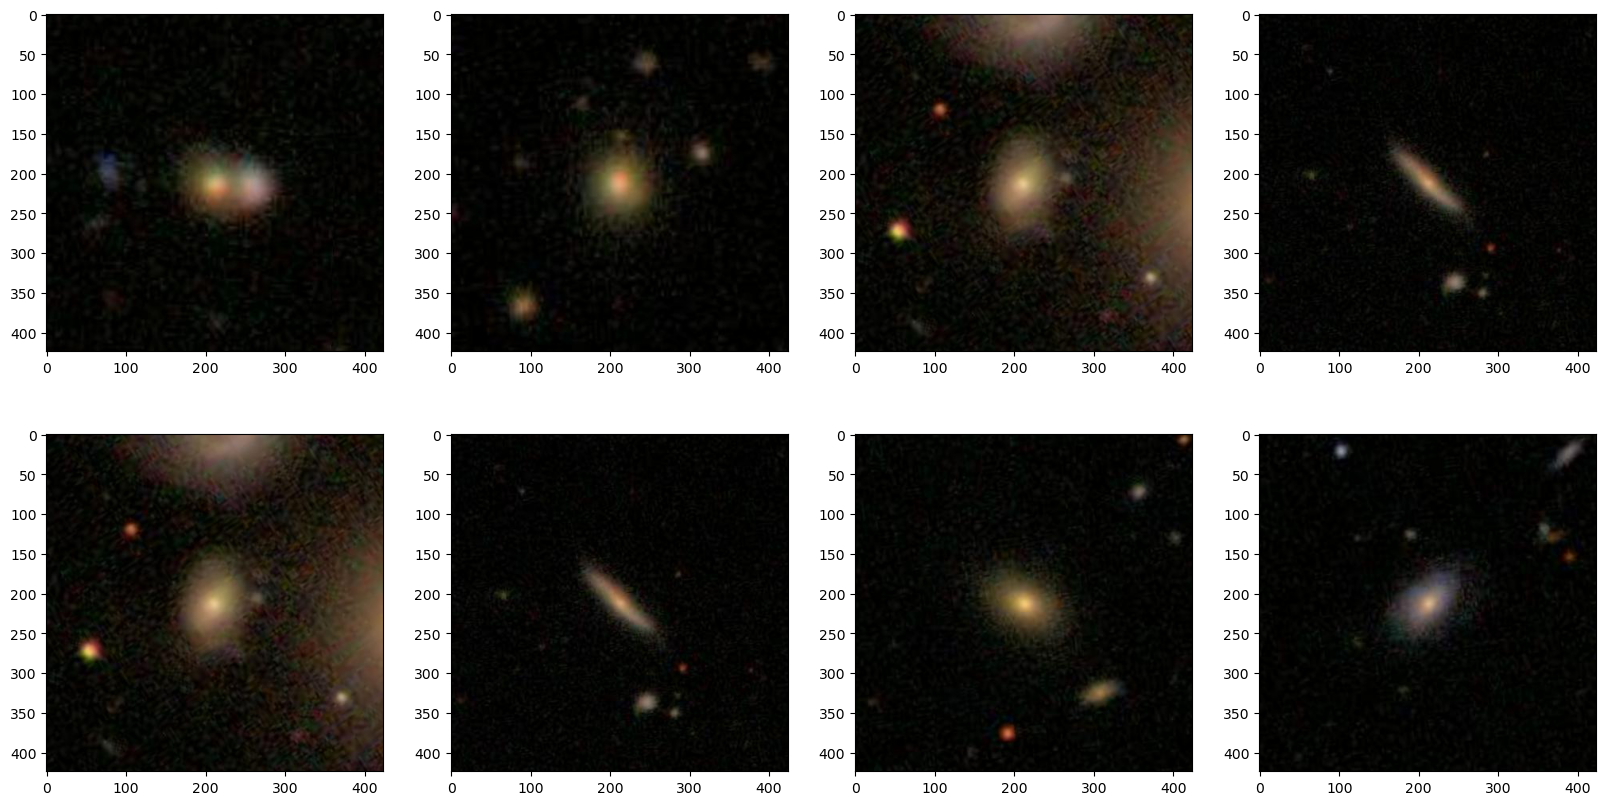

In [7]:
# read image
indx=0
images = []
image_name = []

print('Sample of images in data:')
for idx, img in enumerate(os.listdir(IMAGE_PATH)):
    image_name.append(img)
    img = load_img(
    IMAGE_PATH + img)
    images.append(img)

    

nrows, ncols = 2,4 #print first 8 images
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
for i in range(nrows):
    for j in range(ncols):
        indx = i*nrows+j
        axs[i,j].imshow(images[indx])

Now take a look at the image data and work on getting the mapping from y to be 1 to 1

In [8]:
img_list = []

for i in range(len(image_name)):
    img = int(image_name[i][:-4])
    img_list.append(img)
print('Shape of images:', len(img_list))

y_rel = y_dense[y_dense['image_num'].astype(int).isin(img_list)]
y_rel = y_rel[['image_num', 'label']]
y_rel = y_rel[:10000]


z = y_rel['label'].value_counts()



y_final = y_rel.astype({'image_num':'string'})
print(y_final['image_num'].dtype)
print('Shape of y final:', y_final.shape)

label_ref = y_final.image_num.to_list()

Shape of images: 14060
string
Shape of y final: (10000, 2)


In [9]:
def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 424, 424, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini` 
    # based on temp_no_refer and temp_refer selections
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # read labels
        if img.split('.')[0] in label_ref:
                y_mini.append(y_final[y_final['image_num']==img.split('.')[0]]['label'].item())
        else:
            continue

        
        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(424, 424)
        )
        
        # transform image to array
        img = img_to_array(img)
        
        # append to images
        images_mini.append(img)
       

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [10]:
images_mini, y_mini = preprocess_data_part1(IMAGE_PATH)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (10000, 424, 424, 3)
y_mini shape (10000,)


<Axes: xlabel='count'>

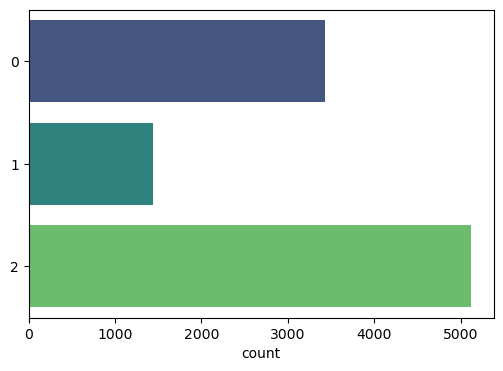

In [11]:
plt.figure(figsize=(6, 4))
sns.countplot(y=y_mini, palette='viridis')

In [12]:
IMAGE_SIZE = (424, 424)
CONTRAST_FACTOR = 3
DELTA = 0.3

def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 424, 424, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0],splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0],splits[0]+splits[1]])
    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_val = tf.image.resize(X_val, size=IMAGE_SIZE)
    X_test = tf.image.resize(X_test, size=IMAGE_SIZE)

    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [13]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

KeyboardInterrupt: 

In [ ]:
# print taining data
print('Print training data examples:')
nrows, ncols = 1,4 #print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_train[i]))
    axs[i].set(title=y_train[i])


In [ ]:
model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)

# add 3rd convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=128,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_3',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_3'))


# add fourth convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_4',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_4')
)

# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
model.add(tf.keras.layers.Dense(
    units=20,
    name='fc_2',
    activation='softmax'))


# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 424, 424, 3))
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(), #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy']) 

In [ ]:
# set random seed to get reproductible results 
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train, y_train_ot,
                    epochs=10, 
                    validation_data=(X_val, y_val_ot)
)

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()